In [1]:
import galsim
import numpy as np
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.animation as anim
from astropy.utils.console import ProgressBar
import warnings
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def set_alts_weights(nlayers):
    """
    set altitudes of each atmosphere layer and its weight on the final psf
    data is generated based on measurements from SCIDAR
    """
    Ellerbroek_alts = [0.0, 2.58, 5.16, 7.73, 12.89, 15.46]  # km
    Ellerbroek_weights = [0.652, 0.172, 0.055, 0.025, 0.074, 0.022]
    Ellerbroek_interp = galsim.LookupTable(Ellerbroek_alts, Ellerbroek_weights,interpolant='linear')
    #create altitude with chosen num of layers
    alts = np.max(Ellerbroek_alts)*np.arange(nlayers)/(nlayers-1)
    #find corresponding weights from table
    weights = Ellerbroek_interp(alts)  # interpolate the weights
    weights /= sum(weights)  # and renormalize
    return alts, weights


def set_wind_spd_dir(nlayers,max_speed,argr0_500,weights,seed):
    """
    setting the wind speed and direction for each atmosphere layer
    """
    #initiate random num
    rng = galsim.BaseDeviate(seed)
    u = galsim.UniformDeviate(rng)
    spd = []  # Wind speed in m/s
    dirn = [] # Wind direction in radians
    r0_500 = [] # Fried parameter in m at a wavelength of 500 nm
    for i in range(nlayers):
        spd.append(u()*max_speed) 
        dirn.append(u()*360*galsim.degrees) 
        r0_500.append(argr0_500*weights[i]**(-3./5))
        """
        print("Adding layer at altitude {:5.2f} km with velocity ({:5.2f}, {:5.2f}) m/s, "
              "and r0_500 {:5.3f} m."
              .format(alts[i], spd[i]*dirn[i].cos(), spd[i]*dirn[i].sin(), r0_500[i]))
        """
    return spd,dirn,r0_500


def create_GSO(t0,theta,lam,aper,time_step,atm):
    """
    create GSO objects for wavefront and PSF
    """    
    #wavefront and psf
    wf = atm.wavefront(aper.u, aper.v, t0, theta=theta) * 2*np.pi/lam  # radians
    psfinst = atm.makePSF(lam=lam, theta=theta, aper=aper,
                      t0=t0, exptime=time_step)
    psfintg = atm.makePSF(lam=lam, theta=theta, aper=aper,
                      t0=t0, exptime=time_step)
    
    return wf, psfinst, psfintg


def update_img(psf_img_sum,PSF, accumulate,i,psf_nx,psf_scale):
    """
    update images for each time step
    """
    psf_img0 = PSF.drawImage(nx=psf_nx, ny=psf_nx, scale=psf_scale)
    if accumulate:
        psf_img_sum += psf_img0
        psf_img_f = psf_img_sum/(i+1)
    else:
        psf_img_f = psf_img0
    # Calculate simple estimate of size and ellipticity
    e = galsim.utilities.unweighted_shape(psf_img_f)
    return psf_img_f, e


def fig_config(fig, psf_inst_ax, psf_intg_ax, wf_ax, psf_vmax, psf_nx, psf_scale, wf_vmax,coor,aper,x,y):
    # Axis for the inst PSF
    fig.set_facecolor("k")
    psf_inst_ax.set_xlabel("Arcsec")
    psf_inst_ax.set_ylabel("Arcsec")
    psf_inst_im = psf_inst_ax.imshow(np.ones((128, 128), dtype=np.float64), animated=True,
                   vmin=0.0, vmax=psf_vmax, cmap='hot',
                   extent=coor*0.5*psf_nx*psf_scale)
    psf_inst_ax.set_title("Instantaneous PSF at (%d', %d')" %(x,y))

    # Axis for the intg PSF
    psf_intg_ax.set_xlabel("Arcsec")
    psf_intg_ax.set_ylabel("Arcsec")
    psf_intg_im = psf_intg_ax.imshow(np.ones((128, 128), dtype=np.float64), animated=True,
                   vmin=0.0, vmax=psf_vmax, cmap='hot',
                   extent=coor*0.5*psf_nx*psf_scale)
    psf_intg_ax.set_title("PSF integrated over time")

    # Axis for the wavefront image on the right.
    wf_ax.set_xlabel("Meters")
    wf_ax.set_ylabel("Meters")
    wf_im = wf_ax.imshow(np.ones((128, 128), dtype=np.float64), animated=True,
                         vmin=-wf_vmax, vmax=wf_vmax, cmap='YlGnBu',
                         extent=np.r_[-1, 1, -1, 1]*0.5*aper.pupil_plane_size)

    divider = make_axes_locatable(wf_ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(wf_im, cax=cax, orientation='vertical')

    # Overlay an alpha-mask on the wavefront image showing which parts are actually illuminated.
    ilum = np.ma.masked_greater(aper.illuminated, 0.5)
    wf_ax.imshow(ilum, alpha=0.4, extent=np.r_[-1, 1, -1, 1]*0.5*aper.pupil_plane_size)

    # Color items white to show up on black background
    for ax in [psf_inst_ax, wf_ax, psf_intg_ax]:
        for _, spine in ax.spines.items():
            spine.set_color('w')
        ax.title.set_color('w')
        ax.xaxis.label.set_color('w')
        ax.yaxis.label.set_color('w')
        ax.tick_params(axis='both', colors='w')


    etext_inst = psf_inst_ax.text(0.05, 0.92, '', transform=psf_inst_ax.transAxes)
    etext_inst.set_color('w')

    etext_intg = psf_intg_ax.text(0.05, 0.92, '', transform=psf_intg_ax.transAxes)
    etext_intg.set_color('w')

    return psf_inst_im, psf_intg_im, wf_im, etext_inst, etext_intg



In [3]:
def main(r0=0.2, numLayers=6, maxspeed=20, lamb0=700, coord=[np.r_[-1,1,-1,1],np.r_[-1,0,-1,0]], xs = [0,0], ys= [0,0]):
    seed = 1
    argr0_500 = r0 #fried parameter at 500nm 
    nlayers = numLayers #num atmospheric layer
    time_step = 0.03 #increment time steps for advancing phase screens
    exptime = 2 # total time to integrate
    screen_size = 102.4 #size of atmospheric screen
    screen_scale = 0.1 #reso of atmospheric screen
    max_speed = maxspeed #max wind speed
    x1 = xs[0] #x coor of psf
    y1 = ys[0] #y coor of psf
    x2 = xs[1] #x coor of psf
    y2 = ys[1] #y coor of psf
    lam = lamb0 #wavelen
    diam =4.0 #size of telescope pupil
    obscuration = 0 #linear fractional obscration of the pupil
    nstruts = 0 #num strurts supporting secondary obscruration
    strut_thick = 0.05 #thickness of struts as fraction of aperture diam
    strut_angle = 0 #starting angle of 1st strut
    psf_nx = 512 #output psf image dimension
    psf_scale = 0.005 # scale of psf output in ''
    accumulate = False
    pad_factor = 1 #factor to pad psf interpolating image to avoid aliasing
    oversampling = 1 #factor to oversample psf interpolated image
    psf_vmax = 0.0003 #vmax kwarg for psf image
    wf_vmax = 50 #vmax kwarg for wavefront image
    outfile = "test1.mp4"
    accumulateint = True
    coor1 = coord[0]
    coor2 = coord[1]
    rng = galsim.BaseDeviate(seed)

    #set altitude of each screen and its weight
    alts, weights = set_alts_weights(nlayers)

    #set wind speed and dir for each screen
    spd,dirn,r0_500 = set_wind_spd_dir(nlayers,max_speed,argr0_500,weights,seed)


    #field angle at which to compute psf
    theta1 = (x1*galsim.arcmin, y1*galsim.arcmin)
    theta2 = (x2*galsim.arcmin, y2*galsim.arcmin)

    #atmosphere layers
    atm = galsim.Atmosphere(r0_500=r0_500, speed=spd, direction=dirn, altitude=alts, rng=rng,
                                screen_size=screen_size, screen_scale=screen_scale)
    #aperture of pupil
    aper = galsim.Aperture(diam=diam, lam=lam, obscuration=obscuration,
                               nstruts=nstruts, strut_thick=strut_thick,
                               strut_angle=strut_angle*galsim.degrees,
                               screen_list=atm, pad_factor=pad_factor,
                               oversampling=oversampling)
    #create Fig frame
    metadata = dict(title='Wavefront Movie', artist='Matplotlib')
    writer = anim.FFMpegWriter(fps=15, bitrate=5000, metadata=metadata)
    fig, ([psf_inst_ax1, wf_ax1, psf_intg_ax1],[psf_inst_ax2, wf_ax2, psf_intg_ax2]) = plt.subplots(nrows=2,ncols=3,figsize=(15,10))
    FigureCanvasAgg(fig)
    
    #configuring figures
    psf_inst_im1, psf_intg_im1, wf_im1, etext_inst1, etext_intg1 = fig_config(fig, psf_inst_ax1, psf_intg_ax1, wf_ax1, 
                                                         psf_vmax, psf_nx, psf_scale, wf_vmax,coor1,aper,x1,y1)
    psf_inst_im2, psf_intg_im2, wf_im2, etext_inst2, etext_intg2 = fig_config(fig, psf_inst_ax2, psf_intg_ax2, wf_ax2, 
                                                         psf_vmax, psf_nx, psf_scale, wf_vmax,coor2,aper,x2,y2)

    nstep = int(exptime / time_step)
    t0 = 0.0

    #store final image
    psf_inst_img_sum1 = galsim.ImageD(psf_nx, psf_nx, scale=psf_scale)
    psf_intg_img_sum1 = galsim.ImageD(psf_nx, psf_nx, scale=psf_scale)
    psf_inst_img_sum2 = galsim.ImageD(psf_nx, psf_nx, scale=psf_scale)
    psf_intg_img_sum2 = galsim.ImageD(psf_nx, psf_nx, scale=psf_scale)
    with ProgressBar(nstep) as bar:
        with writer.saving(fig, "psf_movie_1.mp4", 100):
            for i in range(nstep):
                #create GSobjects
                wf1, psfinst1, psfintg1 = create_GSO(t0,theta1,lam,aper,time_step,atm)
                wf2, psfinst2, psfintg2 = create_GSO(t0,theta2,lam,aper,time_step,atm)

                #draw and update images
                psf_inst_img_f1, e_inst1 = update_img(psf_inst_img_sum1, psfinst1, accumulate, i,psf_nx,psf_scale)
                psf_intg_img_f1, e_intg1 = update_img(psf_intg_img_sum1, psfintg1, accumulateint, i,psf_nx,psf_scale)
                psf_inst_img_f2, e_inst2 = update_img(psf_inst_img_sum2, psfinst2, accumulate, i,psf_nx,psf_scale)
                psf_intg_img_f2, e_intg2 = update_img(psf_intg_img_sum2, psfintg2, accumulateint, i,psf_nx,psf_scale)


                # Update t0 for the next movie frame.
                t0 += time_step

                # Matplotlib code updating plot elements
                wf_im1.set_array(wf1)
                psf_inst_im1.set_array(psf_inst_img_f1.array)
                psf_intg_im1.set_array(psf_intg_img_f1.array)
                wf_ax1.set_title("Wavefront Image. t={:5.2f} s".format(i*time_step))
                etext_inst1.set_text("$e_1$={:6.3f}, $e_2$={:6.3f}, $r^2$={:6.3f}".format(
                    e_inst1['e1'], e_inst1['e2'], e_inst1['rsqr'] * psf_scale ** 2))
                etext_intg1.set_text("$e_1$={:6.3f}, $e_2$={:6.3f}, $r^2$={:6.3f}".format(
                    e_intg1['e1'], e_intg1['e2'], e_intg1['rsqr'] * psf_scale ** 2))

                wf_im2.set_array(wf2)
                psf_inst_im2.set_array(psf_inst_img_f2.array)
                psf_intg_im2.set_array(psf_intg_img_f2.array)
                wf_ax2.set_title("Wavefront Image. t={:5.2f} s".format(i*time_step))
                etext_inst2.set_text("$e_1$={:6.3f}, $e_2$={:6.3f}, $r^2$={:6.3f}".format(
                    e_inst2['e1'], e_inst2['e2'], e_inst2['rsqr'] * psf_scale ** 2))
                etext_intg2.set_text("$e_1$={:6.3f}, $e_2$={:6.3f}, $r^2$={:6.3f}".format(
                    e_intg2['e1'], e_intg2['e2'], e_intg2['rsqr'] * psf_scale ** 2))
                
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    writer.grab_frame(facecolor=fig.get_facecolor())
                bar.update()


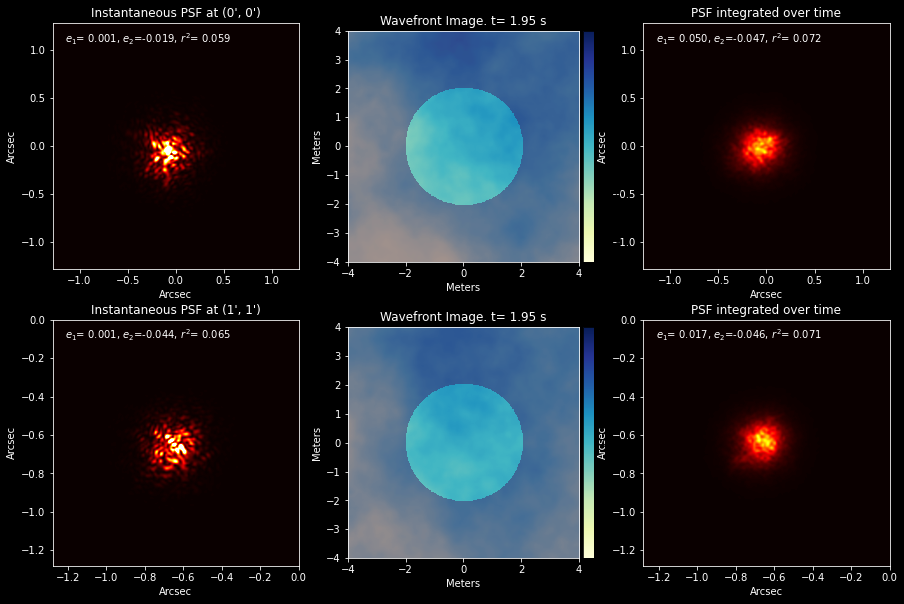

In [4]:
main(coord = [np.r_[-1,1,-1,1], np.r_[-1,0,-1,0]],xs=[0,1],ys=[0,1])